# Periodic Time Series (Chapter 10.3, Second Half)
# Non-Periodic Time Series (Chapter 10.4, 10.5)

By Minghao Yue

Reference: Ivezic Textbook, AstroML online code

In [1]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

# Hack to fix import issue in older versions of pymc
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

## 10.3 Periodic Time Series

Recall that, when we try to fit a sinusoid to the data:
$$y(t)=b_0+a\text{sin}(\omega t)+b\text{cos}(\omega t)$$
one useful tool is the Periodogram:
$$P(\omega) = \frac{1}{N} [ I^2(\omega) + R^2(\omega)]$$
where
$$ I(\omega) = \sum_{j=1}^N y_j \sin(\omega t_j),\quad R(\omega) = \sum_{j=1}^N y_j \cos(\omega t_j)$$
and the Lomb-Scargle Periodogram:
$$ P_{LS}(\omega) = \frac{2}{NV} P(\omega) $$
where
$$ $$
$$V = \frac{1}{N} \sum_{j=1}^N y_j^2, \quad S(\omega) = \sum_{j=1}^N \sin^2(\omega t_j),\quad C(\omega) = \sum_{j=1}^N \cos^2(\omega t_j)$$
The Lomb-Scargle Periodogram can be intepretated as "how better can we go if we fit a sinusoid to the data than a constant value":
$$\chi^2(\omega)=\chi_0^2[1-P_{LS}(\omega)]$$

### Truncated Fourier Series Model
We can generalize the sinusoid model from one term to multiple terms:
$$y(t)=b_0+\sum^M_{m=1}a_m\text{sin}(m\omega t)+b_m\text{cos}(m\omega t)$$
We can also calculate the (normalized) Periodogram of this fitting:
$$P_M(\omega)=\frac{2}{V}\sum^M_{m=1}[I_m(\omega)^2+R_m(\omega)^2]$$
where
$$
I_m(\omega)=\sum^N_{j=1}w_jy_j\text{sin}(m\omega t_j), \quad R_m(\omega)=\sum^N_{j=1}w_jy_j\text{cos}(m\omega t_j)
$$
The Periodogram of $M$ harmonics will be larger if $M$ harmonics is a better model than one harmonic function.
When the shape of the light curve significantly deviates from a sinusoid, this method can be useful.

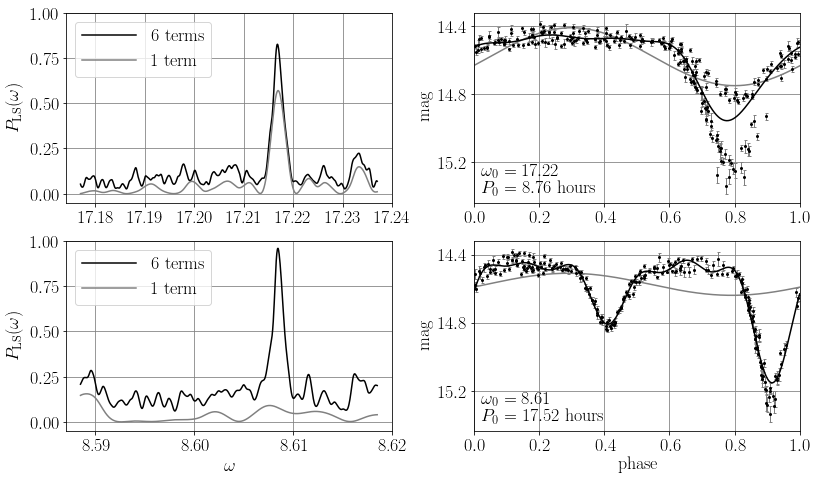

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from astroML.time_series import multiterm_periodogram, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

#------------------------------------------------------------
# Get data
data = fetch_LINEAR_sample()
t, y, dy = data[14752041].T

#------------------------------------------------------------
# Do a single-term and multi-term fit around the peak
omega0 = 17.217
nterms_fit = 6

# hack to get better phases: this doesn't change results,
#  except for how the phase plots are displayed
t -= 0.4 * np.pi / omega0

width = 0.03
omega = np.linspace(omega0 - width - 0.01, omega0 + width - 0.01, 1000)

#------------------------------------------------------------
# Compute periodograms and best-fit solutions
#  factor gives the factor that we're dividing the fundamental frequency by
factors = [1, 2]
nterms = [1, 6]

# Compute PSDs for factors & nterms
PSDs = dict()
for f in factors:
    for n in nterms:
        PSDs[(f, n)] = multiterm_periodogram(t, y, dy, omega / f, n)

# Compute the best-fit omega from the 6-term fit
omega_best = dict()
for f in factors:
    omegaf = omega / f
    PSDf = PSDs[(f, 6)]
    omega_best[f] = omegaf[np.argmax(PSDf)]

# Compute the best-fit solution based on the fundamental frequency
best_fit = dict()
for f in factors:
    for n in nterms:
        mtf = MultiTermFit(omega_best[f], n)
        mtf.fit(t, y, dy)
        phase_best, y_best = mtf.predict(1000, adjust_offset=False)

        best_fit[(f, n)] = (phase_best, y_best)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.12, top=0.95, hspace=0.2)

for i, f in enumerate(factors):
    P_best = 2 * np.pi / omega_best[f]
    phase_best = (t / P_best) % 1

    # first column: plot the PSD
    ax1 = fig.add_subplot(221 + 2 * i)
    ax1.plot(omega / f, PSDs[(f, 6)], '-', c='black', label='6 terms')
    ax1.plot(omega / f, PSDs[(f, 1)], '-', c='gray', label='1 term')
    ax1.grid(color='gray')
    ax1.legend(loc=2)

    ax1.axis('tight')
    ax1.set_ylim(-0.05, 1.001)
    ax1.xaxis.set_major_locator(plt.MultipleLocator(0.01))
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    # second column: plot the phased data & fit
    ax2 = fig.add_subplot(222 + 2 * i)
    ax2.errorbar(phase_best, y, dy, fmt='.k', ms=4, ecolor='gray', lw=1,
                 capsize=1.5)
    ax2.plot(best_fit[(f, 1)][0], best_fit[(f, 1)][1], '-', c='gray')
    ax2.plot(best_fit[(f, 6)][0], best_fit[(f, 6)][1], '-', c='black')

    ax2.text(0.02, 0.02, (r"$\omega_0 = %.2f$" % omega_best[f] + "\n"
                          + r"$P_0 = %.2f\ {\rm hours}$" % (24 * P_best)),
             ha='left', va='bottom', transform=ax2.transAxes)

    ax2.grid(color='gray')
    ax2.set_xlim(0, 1)
    ax2.set_ylim(plt.ylim()[::-1])
    ax2.yaxis.set_major_locator(plt.MultipleLocator(0.4))

    # label both axes
    ax1.set_ylabel(r'$P_{\rm LS}(\omega)$')
    ax2.set_ylabel(r'${\rm mag}$')
    if i == 1:
        ax1.set_xlabel(r'$\omega$')
        ax2.set_xlabel(r'${\rm phase}$')

plt.show()



### Time-Variability Based Classification
Fitting the light curve gives us information that can be used in classification (e.g., is a variable star a eclipsing binary or a Cepheid?).

Usually the time-variability information is combined with other information (for example, colors) to get a better classification performance.

Here we show an example of supervised classification using Support Vector Machine method.

/home/ymh/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


class  completeness  contamination
ab RRL       0.959      0.030
c RRL        0.913      0.116
EA           0.964      0.018
EB/EW        0.675      0.316
SX Phe       0.908      0.095


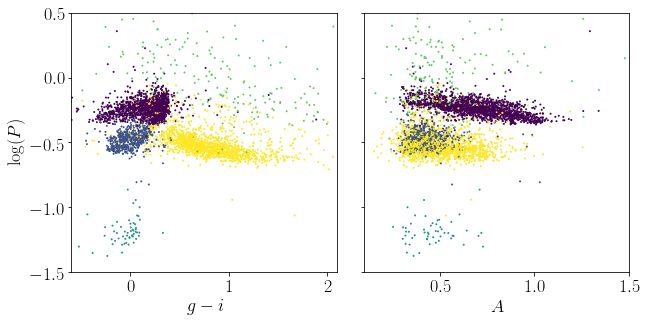

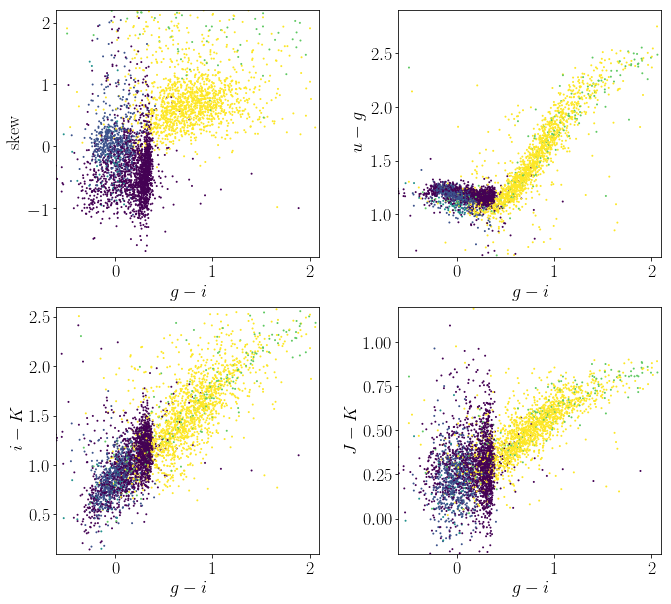

In [3]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from astroML.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_geneva
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

data = fetch_LINEAR_geneva()

attributes = [('gi', 'logP'),
              ('gi', 'logP', 'ug', 'iK', 'JK', 'amp', 'skew')]
labels = ['$u-g$', '$g-i$', '$i-K$', '$J-K$',
          r'$\log(P)$', 'amplitude', 'skew']
cls = 'LCtype'
Ntrain = 3000

#------------------------------------------------------------
# Create attribute arrays
X = []
y = []

for attr in attributes:
    X.append(np.vstack([data[a] for a in attr]).T)
    LCtype = data[cls].copy()

    # there is no #3.  For a better color scheme in plots,
    # we'll set 6->3
    LCtype[LCtype == 6] = 3
    y.append(LCtype)


#@pickle_results('LINEAR_SVM.pkl')
def compute_SVM_results(i_train, i_test):
    classifiers = []
    predictions = []
    Xtests = []
    ytests = []
    Xtrains = []
    ytrains = []

    for i in range(len(attributes)):
        Xtrain = X[i][i_train]
        Xtest = X[i][i_test]
        ytrain = y[i][i_train]
        ytest = y[i][i_test]

        clf = SVC(kernel='linear', class_weight=None)
        clf.fit(Xtrain, ytrain)
        y_pred = clf.predict(Xtest)

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions


i = np.arange(len(data))
i_train, i_test = train_test_split(i, random_state=0, train_size=2000)
clfs, ypred = compute_SVM_results(i_train, i_test)
#'''
classes=['ab RRL','c RRL','EA','EB/EW ','SX Phe']
print 'class  completeness  contamination'

for index in range(1,6,1):
    ytest0=y[1][i_test]
    ypred0=ypred[1]
    
    select0=(ytest0==index)
    select1=(ypred0==index)
    
    #ytest0[:]=0
    ypred_class=ypred0.copy()
    ytest_class=ytest0.copy()
    
    
    ytest_class[~select0]=0
    
    #ypred0[:]=0
    ypred_class[~select1]=0
    
    completeness,contamination=completeness_contamination(ypred_class, ytest_class)
    print '%-10s   %-.3f      %-.3f'%(classes[index-1],completeness,contamination)
    
#'''
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

class_labels = []

for i in range(1,2):
    Xtest = X[i][i_test]
    ytest = y[i][i_test]
    amp = data['amp'][i_test]
    
    # Plot the resulting classifications
    ax1 = fig.add_subplot(221 + 2 * i)
    ax1.scatter(Xtest[:, 0], Xtest[:, 1],
                c=ypred[i], edgecolors='none', s=4, linewidths=0)

    ax1.set_ylabel(r'$\log(P)$')

    ax2 = plt.subplot(222 + 2 * i)
    ax2.scatter(amp, Xtest[:, 1],
                c=ypred[i], edgecolors='none', s=4, lw=0)

    #------------------------------
    # set axis limits
    ax1.set_xlim(-0.6, 2.1)
    ax2.set_xlim(0.1, 1.5)
    ax1.set_ylim(-1.5, 0.5)
    ax2.set_ylim(-1.5, 0.5)

    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    if i == 0:
        ax1.xaxis.set_major_formatter(plt.NullFormatter())
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax1.set_xlabel(r'$g-i$')
        ax2.set_xlabel(r'$A$')

#plt.plot()
        
#------------------------------------------------------------
# Second figure
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.3)

attrs = ['skew', 'ug', 'iK', 'JK']
labels = ['skew', '$u-g$', '$i-K$', '$J-K$']
ylims = [(-1.8, 2.2), (0.6, 2.9), (0.1, 2.6), (-0.2, 1.2)]

for i in range(4):
    ax = fig.add_subplot(221 + i)
    ax.scatter(data['gi'][i_test], data[attrs[i]][i_test],
               c=ypred[1], edgecolors='none', s=4, lw=0)
    ax.set_xlabel('$g-i$')
    ax.set_ylabel(labels[i])

    ax.set_xlim(-0.6, 2.1)
    ax.set_ylim(ylims[i])

#------------------------------------------------------------
# Save the results
#
# run the script as
#
#   >$ python fig_LINEAR_clustering.py --save
#
# to output the data file showing the cluster labels of each point
    '''
import sys
if len(sys.argv) > 1 and sys.argv[1] == '--save':
    filename = 'cluster_labels_svm.dat'

    print "Saving cluster labels to %s" % filename

    from astroML.datasets.LINEAR_sample import ARCHIVE_DTYPE
    new_data = np.zeros(len(data),
                        dtype=(ARCHIVE_DTYPE + [('2D_cluster_ID', 'i4'),
                                                ('7D_cluster_ID', 'i4')]))
    
    # switch the labels back 3->6
    for i in range(2):
        ypred[i][ypred[i] == 3] = 6

    # need to put labels back in order
    class_labels = [-999 * np.ones(len(data)) for i in range(2)]
    for i in range(2):
        class_labels[i][i_test] = ypred[i]

    for name in data.dtype.names:
        new_data[name] = data[name]
    new_data['2D_cluster_ID'] = class_labels[0]
    new_data['7D_cluster_ID'] = class_labels[1]

    fmt = ('%.6f   %.6f   %.3f   %.3f   %.3f   %.3f   %.7f   %.3f   %.3f   '
           '%.3f    %.2f     %i     %i      %s          %i              %i\n')


    F = open(filename, 'w')
    F.write('#    ra           dec       ug      gi      iK      JK     '
            'logP       Ampl    skew      kurt    magMed    nObs  LCtype  '
            'LINEARobjectID  2D_cluster_ID   7D_cluster_ID\n')
    for line in new_data:
        F.write(fmt % tuple(line[col] for col in line.dtype.names))
    F.close()
    '''

plt.show(fig)

## 10.4 Temporally Localized Signal
Many time-varying signals are localized in time (e.g., a burst, a microlensing event, and a gravitational wave event). They can be described as:
$$y(t)=y_0+\epsilon+y_b(t)$$
where
$$y_b(t)=Ag(t-T|\bf{\theta})$$
is the time-dependent signal, $y_0$ is the stationary signal, and $\epsilon$ is the error.

The gravitational wave signal is a good example of a temporally localized signal:
![ligo](ligo.jpg)

If we know the burst model $g_b(t-T|\theta)$ and the noise model, we can apply model selections and parameter estimation on the data (e.g., Maximum Likelihood Estimation, Bayesian analysis, etc).

Here we play with a toy model, where $y(t)=b_0+A\text{sin}(\omega t+\beta t^2)$, and the errors are Gaussian. We use MCMC to calculate the posterior PDF of the parameters.

@pickle_results: using precomputed results from 'matchedfilt_chirp.pkl'


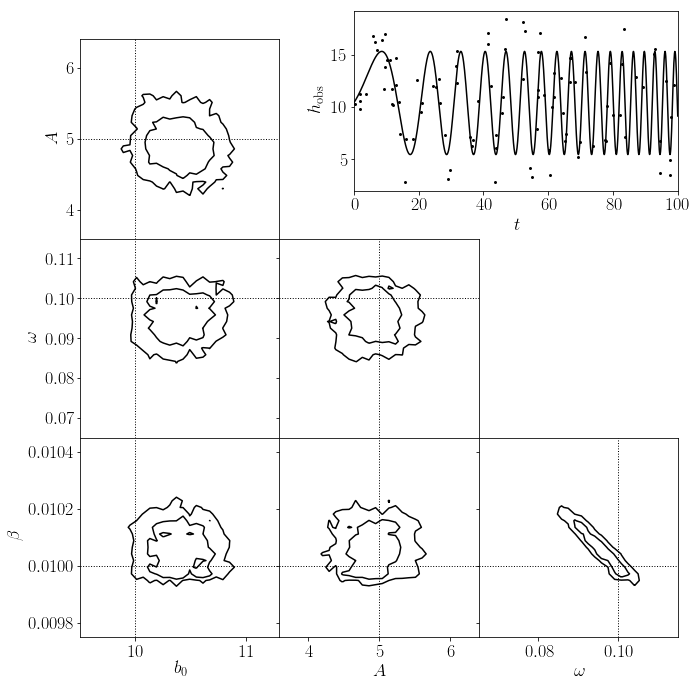

In [4]:
#----------------------------------------------------------------------
# Set up toy dataset
def chirp(t, b0, beta, A, omega):
    return b0 + A * np.sin(omega * t + beta * t * t)

np.random.seed(0)

N = 100
b0_true = 10
A_true = 5
beta_true = 0.01
omega_true = 0.1
sigma = 2.0

t = 100 * np.random.random(N)

y_true = chirp(t, b0_true, beta_true, A_true, omega_true)
y_obs = np.random.normal(y_true, sigma)

t_fit = np.linspace(0, 100, 1000)
y_fit = chirp(t_fit, b0_true, beta_true, A_true, omega_true)

i = np.argsort(t)

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
log_beta = pymc.Uniform('log_beta', -10, 10, value=-4.6)
log_omega = pymc.Uniform('log_omega', -10, 10, value=-2.3)


# uniform prior on log(beta)
@pymc.deterministic
def beta(log_beta=log_beta):
    return np.exp(log_beta)


# uniform prior on log(omega)
@pymc.deterministic
def omega(log_omega=log_omega):
    return np.exp(log_omega)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, beta=beta, omega=omega):
    return chirp(t, b0, beta, A, omega)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A,
             log_beta=log_beta, beta=beta,
             log_omega=log_omega, omega=omega,
             y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling (saving results to a pickle)
@pickle_results('matchedfilt_chirp.pkl')
def compute_MCMC_results(niter=20000, burn=2000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'omega', 'beta']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.beta.value, M.A.value, M.omega.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', r'$\omega$', r'$\beta$']
limits = [(9.5, 11.3), (3.6, 6.4), (0.065, 0.115), (0.00975, 0.01045)]
true = [b0_true, A_true, omega_true, beta_true]

#----------------------------------------------------------------------
# Find the Maximum a posteriori values
fig = plt.figure(figsize=(10, 10))

ax = plt.axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1001)
y_fit = chirp(t_fit, *fit_vals)
plt.scatter(t, y_obs, s=9, lw=0, c='k')
plt.plot(t_fit, y_fit, '-k')
plt.xlim(0, 100)
plt.xlabel('$t$')
plt.ylabel(r'$h_{\rm obs}$')

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, bounds=[0.12, 0.08, 0.95, 0.91], colors='k')
plt.show()

## 10.5 Stochastic Processes

Another case of interest is that the signal is unpredictable forever  (unlike periodic signals), but the variability always exists (unlike temporally localized signals).

Stochastic processes might look like random noise, but they can still be quantitavely described.

An example from daily life...
![stock](stock.gif)

### The Autocorrelation Function

The autocorrelation is based on the correlation function ($\text{CF}$):
$$\text{CF}(\Delta t)=\frac{\text{lim}_{T\rightarrow\infty}\frac{1}{T}\int _ {(T)} f(t)g(t+\Delta t) dt}{\sigma_f \sigma_g}$$
if we take $g(t)=f(t)=y(t)$, we will get the autocorrelation function ($\text{ACF}$):
$$
\text{ACF}(\Delta t)=\frac{\text{lim} _ {T\rightarrow\infty}\frac{1}{T}\int _ {(T)} y(t)y(t+\Delta t) dt}{\sigma_y^2}
$$

What is the physical meaning of the autocorrelation function? 

If the signal at time $t$ is influenced by the previous states, i.e., the signals between $t-\tau$ and $t$, then $\text{ACF}(\Delta t)$ will has a non-zero value for $\Delta t<\tau$, and goes to zero at $\Delta t>\tau$. Similarly, if $\text{ACF}(\Delta t)$ vanishes at $\Delta t > \tau$, the status of the system can only influence the close future within time $\tau$.



Some properties of the autocorrelation function:

(1) $\text{ACF}(0)=1$

(2) $\text{ACF}(\infty) \rightarrow  0$ if the signal is influenced by a limited period of history.

(3) $\text{ACF}(t)$ and $\text{PSD}(f)$ are Fourier pairs (Wiener–Khinchin theorem).

(Recall $\text{PSD}(f)=|H(f)|^2+|H(-f)|^2$, where $H(f)$ is the Fourier transformation of the signal.)

### The Structure Function
Another quantity frequently used is the Structure Function:
$$\text{SF}(\Delta t)=\text{SF}_\infty[1-\text{ACF}(\Delta t)]^{1/2}$$
where $\text{SF}_\infty$ is the standard deviation of the time series evaluated over an infinitely large time interval.

### ACF of Evenly Sampled Data
For evenly sampled data, where $t_i=(i-1)\Delta t$, the calculation of ACF is straightforward:
$$\text{ACF}(j)=\frac{\sum^{N-j}_{i=1}[(y_i-\bar{y})(y_{i+j}-\bar{y})]}{\sum^N_{i=1}(y_i-\bar{y})^2}$$
which is just the discrete version of the definition.

One related topic. If the measurements of a quantity has non-zero ACF, the the uncertainty of its mean is larger than the case of vanishing ACF:
$$\sigma_{\bar{x}}=\frac{\sigma}{\sqrt{N}}[1+2\sum^{N}_{j=1}(1-\frac{j}{N})\text{ACF}(j)]^{1/2}$$
That is why we need to pay attention to whether the measurements are correlated or independent.

### ACF of Unevenly Sampled Data
Real life is more difficult; in many cases, the signal is not evenly sampled.
#### The Discrete Correlation Function (DCF)
Consider the more general case: the correlation function of two signals $y(t)$ and $g(t)$. We first define a quantity:
$$\text{UDCF}_{ij}=\frac{(y_i-\bar{y})(g_j-\bar{g})}{[(\sigma_y^2-e_y^2)(\sigma_g^2-e_g^2)]^{1/2}}$$

Then we average the value of $\text{UDCF}_{ij}$ which satisfies $\Delta t-\delta t/2 < \Delta t_{ij} < \Delta t+\delta t/2$ to estimate $\text{CF}(\Delta t)$.
#### Scargle's Approach
Scargle proposed another way of estimating the ACF with unevenly sampled signal. This approach makes use of the fact that $\text{ACF}(t)$ and $\text{PSD}(f)$ are Fourier pairs. The steps are as follows:

(1) Calculate the generalized Lomb–Scargle periodogram for $y_i(t)$, namely $P_\text{LS}(\omega)$, and the Lomb–Scargle periodogram for the window function, namely $P_\text{LS}^W(\omega)$.

(2) Compute inverse Fourier transforms for $P_\text{LS}(\omega)$ and $P_\text{LS}^W(\omega)$, namely $\rho(t)$ and $\rho^W(t)$.

(3) $\text{ACF}(t)=\rho(t) / \rho^W(t)$

### Examples of Stochastic Processes

The most famous example of the stochastic process might be the random walk:
$$y_{i}=y_{i-1}+e_i$$
It can be generalized to the linear autoregressive model, $\text{AR}(k)$:
$$y_i=c+\sum^k_{j=1}a_jy_{i-j}+e_i$$
To make AR available for unevenly sampled signal, we can generalize it to the
continuous autoregressive model, $\text{CAR}(k)$.
The $\text{CAR}(1)$ process is of great interest because it can describe the variability of quasars.

### Damped Random Walk

Damped random walk is a special case of $\text{CAR}(1)$ process. In the corresponding discrete version, we have
$y_i=a_1y_{i-1}+e_i$, or
$$ y_i-y_{i-1} = (a_1-1)y_{i-1}+e_i$$
In the case of $a_1<1$, the sign of $y_i-y_{i-1}$ is likely to be different from $ y_{i-1}$, which means that the value of $y$ always tends to go back to $0$. The word "damped" means that something is pushing $y(t)$ back to its mean value.

The $\text{ACF}$ of a damped random walk process can be described as
$$
\text{ACF}(t)=\text{exp}(-t/\tau)
$$

AstroML provides functions to generate damped random walk signals.

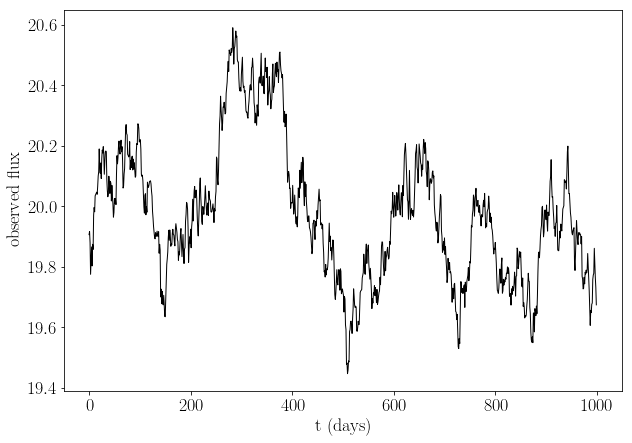

In [5]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from astroML.time_series import lomb_scargle, generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

t = np.arange(0, 1E3)
z = 2.0
tau = 300
tau_obs = tau / (1. + z)

np.random.seed(6)

# Generate the Damped Random Walk signal
y = generate_damped_RW(t, tau=tau, z=z, xmean=20)

# Plot the results
fig = plt.figure(figsize=(10, 7))

# plot the input data
ax = fig.add_subplot(111)
ax.plot(t, y, 'k-', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

plt.show()


Now we use AstroML to generate a damped random walk signal which is unevenly sampled, and calculate its ACF using methods mentioned above.

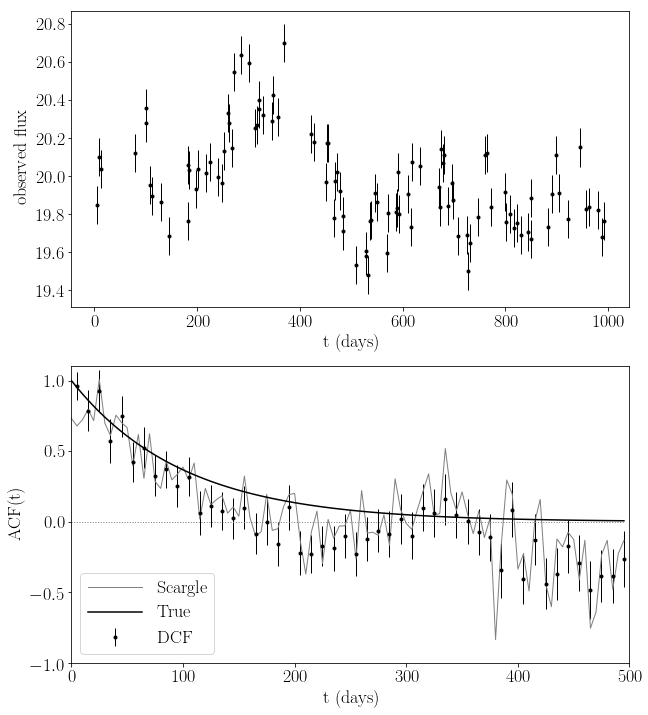

In [6]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

#------------------------------------------------------------
# Generate time-series data:
#  we'll do 1000 days worth of magnitudes

t = np.arange(0, 1E3)
z = 2.0
tau = 300
tau_obs = tau / (1. + z)

np.random.seed(6)
y = generate_damped_RW(t, tau=tau, z=z, xmean=20)

# randomly sample 100 of these
ind = np.arange(len(t))
np.random.shuffle(ind)
ind = ind[:100]
ind.sort()
t = t[ind]
y = y[ind]

# add errors
dy = 0.1
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# compute ACF via scargle method
C_S, t_S = ACF_scargle(t, y_obs, dy,
                       n_omega=2 ** 12, omega_max=np.pi / 5.0)

ind = (t_S >= 0) & (t_S <= 500)
t_S = t_S[ind]
C_S = C_S[ind]

#------------------------------------------------------------
# compute ACF via E-K method
C_EK, C_EK_err, bins = ACF_EK(t, y_obs, dy, bins=np.linspace(0, 500, 51))
t_EK = 0.5 * (bins[1:] + bins[:-1])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 12))

# plot the input data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
ax.plot(t_S, C_S, '-', c='gray', lw=1,
        label='Scargle')
ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1,
            label='DCF')
ax.plot(t_S, np.exp(-abs(t_S) / tau_obs), '-k', label='True')
ax.legend(loc=3)

ax.plot(t_S, 0 * t_S, ':', lw=1, c='gray')

ax.set_xlim(0, 500)
ax.set_ylim(-1.0, 1.1)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

plt.show()

# 10.6 Which Method Should I Use for Time Series Analysis?

For periodic signals,
- Analysis in the frequency space (i.e., Fourier transformation, wavelet transformation) is very useful, since the signal is more concentrated in the frequency space

- The matched filter analysis can greatly improved the ability of detecting a signal

- The Lomb–Scargle method is very powerful for astronomical data (low SNR, unevenly sampled)

For stochastic signals,
- Autocorrelation function and structure function is frequently used
- Many new techniques are getting developed (see the textbook for details)